In [1]:
# Import library
import numpy as np
import adi
import matplotlib.pyplot as plt
import scipy

In [2]:
# config TX



sample_rate = int(3e9)    # the sampling frequency we use for the discrete simulation of analog signals
center_freq = int(1e9)
num_datasymbols = 64
sps = 8

Ts = sps/sample_rate

num_taps = 5*sps+1 #number of taps for rrc


num_samps = 2*(num_datasymbols*sps + num_taps - 1) # number of samples per call to rx(): 2 frames

In [3]:
# root raised cosine filter --> split filtering between RX and TX
def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.

    Parameters
    ----------
    N : int
        Length of the filter in samples.

    alpha : float
        Roll off factor (Valid values are [0, 1]).

    Ts : float
        Symbol period in seconds.

    Fs : float
        Sampling Rate in Hz.

    Returns
    ---------

    time_idx : 1-D ndarray of floats
        Array containing the time indices, in seconds, for
        the impulse response.

    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return time_idx, h_rrc



[ 1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1  1  1]


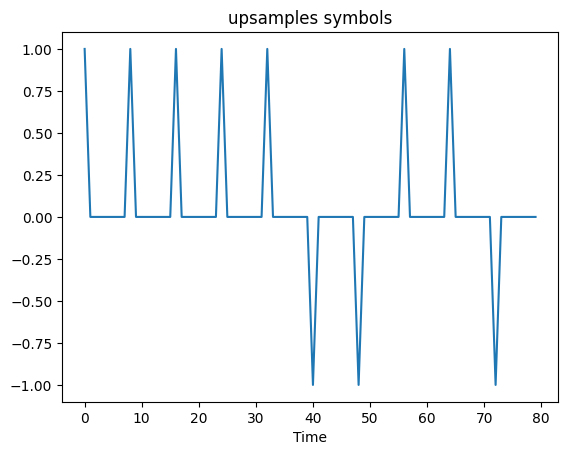

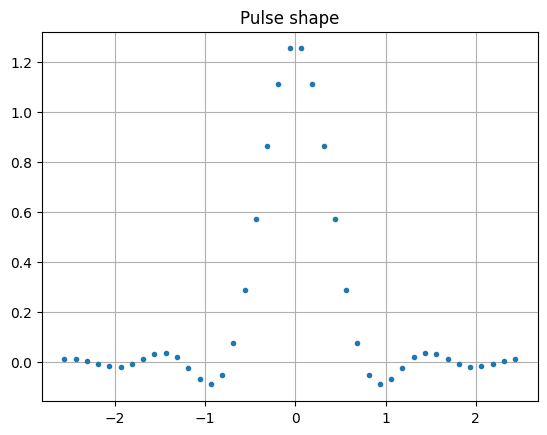

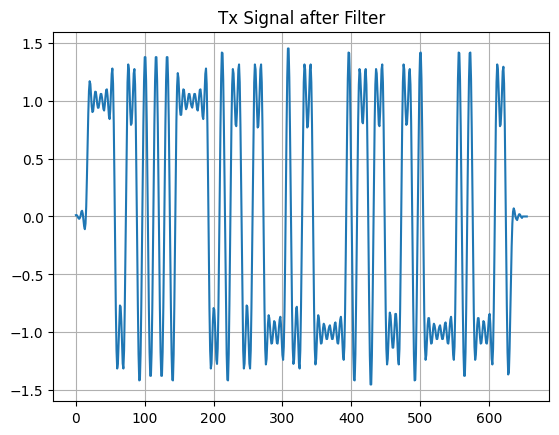

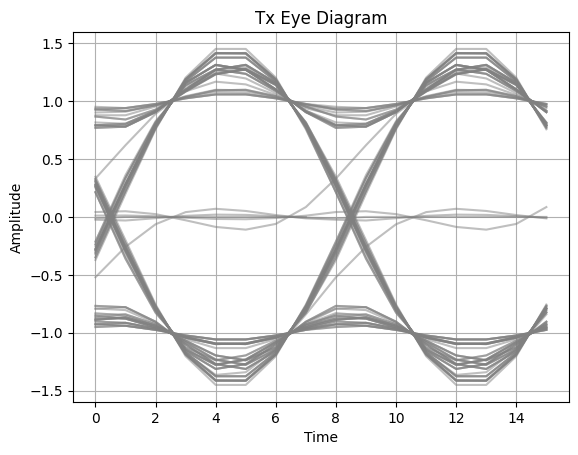

In [4]:
# Create transmit waveform (BPSK, sps samples per symbol)
bits = np.random.randint(0, 2, num_datasymbols) # 0 to 1
symbols = bits*2 - 1

# preamble (Barker)
barker = np.array([1,1,1,1,1,-1,-1,1,1,-1,1,-1,1])
preamble = barker
symbols = np.concatenate((preamble, symbols))
num_symbols = symbols.size

print(symbols[:20])

#upsampling based on sps
up_sym = np.array([])
for sym in symbols:
    temp = np.zeros(sps)
    temp[0] = sym
    up_sym = np.concatenate((up_sym, temp))

# print(up_sym[:3*sps])

# Plot time domain
plt.figure(0)
plt.plot(up_sym[:10*sps])
plt.xlabel("Time")
plt.title("upsamples symbols")

# Create our raised-cosine filter
beta = 1
# Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8 --> I changed the sample rate 
t, h_pulse = rrcosfilter(num_taps, beta, Ts=1, Fs=sps)


# Plot rrc
plt.figure(1)
plt.plot(t, h_pulse, '.')
plt.grid(True)
plt.title("Pulse shape")
plt.show()

# Filter our signal, in order to apply the pulse shaping
# 1. rrc filter
x_shaped = np.convolve(up_sym, h_pulse)

# 2. rectangle filter
# x_shaped = np.repeat(symbols, sps) # 16 samples per symbol (rectangular pulses)


plt.figure(2)
# plt.plot(x_shaped[num_taps//2:num_taps//2 + 10*sps])
plt.plot(x_shaped)
plt.title("Tx Signal after Filter")
# for i in range(num_datasymbols):
#     plt.plot([i*sps+num_taps//2,i*sps+num_taps//2], [0, x_shaped[i*sps+num_taps//2]])
plt.grid(True)
plt.show()


# Create the eye diagram
plt.figure(3)
for k in range(len(x_shaped)):
    plt.plot(x_shaped[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tx Eye Diagram')
plt.grid(True)
plt.show()


# upconvert to center_freq
t_u = np.arange(len(x_shaped))/sample_rate
x_tx = x_shaped*np.exp(1j*2*np.pi*int(center_freq)*t_u)


In [5]:
movements = 5
theoretical_phase = []
found_phase = []
delays = []
for i in range(movements):
    # delays.append(np.random.randint(0, (sample_rate/center_freq)-1)) #very strict bounds
    delays.append(3*i) #prove phase wrap-around
    
for i in range(movements):

    # create channel
    
    channelResponse = np.zeros(delays[i])
    channelResponse = np.append(channelResponse, 1) 
    
    # print("channel response", channelResponse)
    
    SNRdb = 25 # SNR in dB at the receiver
    
    
    # go through simulated channel
    def channel(signal):
        convolved = np.convolve(signal, channelResponse)
        signal_power = np.mean(abs(convolved**2))
        sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
        
        # print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
        
        # Generate complex noise with given variance
        noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
        
        return convolved+noise 
    
    
    
    # down conversion
    rx = channel(x_tx)
    t_d = np.arange(len(rx))/sample_rate
    rx_samples = rx*np.exp(1j*-2*np.pi*int(center_freq)*t_d)
    
    # plt.figure(figsize=(8,2))
    # plt.plot(abs(x_shaped), label='TX signal')
    # plt.plot(abs(rx_samples), label='RX signal')
    # plt.legend(fontsize=10)
    # plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
    # plt.title("TX and RX signal")
    # plt.grid(True);
    
    # matched filter
    # 1. rrc filter
    rx_matched = np.convolve(rx_samples, h_pulse) #recall h_pulse is impulse response of root raised cosine filter
    # 2. rectangle filter
    # rx_matched = rx_samples
    
    # Calculate power spectral density (frequency domain version of signal)
    psdraw = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
    psdraw_dB = 10*np.log10(psdraw)
    
    psd = np.abs(np.fft.fftshift(np.fft.fft(rx_matched)))**2
    psd_dB = 10*np.log10(psd)
    
    f = np.linspace(sample_rate/-2, sample_rate/2, len(psdraw))
    f_match = np.linspace(sample_rate/-2, sample_rate/2, len(psd))
    
    # # this is after matched filtering 
    # # Plot time domain
    # plt.figure(0)
    # plt.subplot(1,2,1)
    # plt.plot(np.real(rx_samples[:40*sps]))
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("raw rx samples")
    # plt.figure(0)
    # plt.subplot(1,2,2)
    # plt.plot(np.real(rx_matched[:40*sps]))
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("raw rx matched")
    
    
    # # Create the eye diagram
    # plt.figure(1)
    # plt.subplot(1,2,1)
    # for k in range(len(rx_samples)):
    #     plt.plot(rx_samples[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('raw')
    # plt.grid(True)
    # plt.subplot(1,2,2)
    # for k in range(len(rx_matched)):
    #     plt.plot(rx_matched[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('matched')
    # plt.grid(True)
    # plt.show()
    
    
    # # Plot freq domain
    # plt.figure(2)
    # plt.subplot(1,2,1)
    # plt.plot(f/sample_rate, psdraw_dB)
    # plt.xlabel("Frequency [MHz]")
    # plt.ylabel("PSD")
    # plt.title('raw')
    
    # plt.subplot(1,2,2)
    # plt.plot(f_match/sample_rate, psd_dB)
    # plt.xlabel("Frequency [MHz]")
    # plt.ylabel("PSD")
    # plt.title('matched')
    
    plt.show()
    
    # pulse alignment
    
    # drop samples to remove filtering transition: not necessary because time-async
    rx_static = rx_matched[num_taps:-num_taps]
    Npacket_samples = x_shaped.size
    
    
    # # Plot time domain
    # plt.figure
    # plt.subplot(1,2,1)
    # plt.plot(np.real(rx_matched[:Npacket_samples]))
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("raw rx match")
    # plt.subplot(1,2,2)
    # plt.plot(np.real(rx_static[:Npacket_samples]))
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("raw rx static")
    # plt.show()
    
    # choose the sample at which energy is largest and align as so
    # print(np.abs(rx_matched))
    energy = np.zeros(sps)
    for k in range(sps):
        energy[k] = sum( np.absolute(rx_static[k::sps]))
    
    # symbols_sps = np.zeros((sps, np.size(rx_static)//sps+1))
    # for k in range(sps):
    #     symbols_sps[k] = rx_static[k::sps]
    
    # align the samples
    max_ind = np.argmax(energy)
    # print(max_ind)
    rx_align = rx_static[max_ind:]
    # print("max index for sample pulse alignments is", max_ind)
    
    
    # # Plot freq domain
    # plt.figure
    # plt.plot(energy)
    # plt.title("maximum energy based on sample")
    # plt.show()
    
    
    # # Create the eye diagram
    # plt.figure
    # plt.subplot(1,2,1)
    # for k in range(len(rx_static)):
    #     plt.plot(np.real(rx_static[k * sps:(k + 2) * sps]), color='gray', alpha=0.5)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('matched (real)')
    # plt.grid(True)
    # plt.subplot(1,2,2)
    # for k in range(len(rx_align)):
    #     plt.plot(np.real(rx_align[k * sps:(k + 2) * sps]), color='gray', alpha=0.5)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('aligned (real)')
    # plt.grid(True)
    # plt.show()
    
    # constellation
    
    #sample back to symbol
    rx_symbols = rx_align[::sps]
    
    
    # # Plot time domain
    # plt.figure
    # plt.subplot(1,2,1)
    # plt.plot(rx_symbols.real)
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("rx symbols real")
    # plt.subplot(1,2,2)
    # plt.plot(rx_symbols.imag)
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("rx symbols imag")
    # plt.show()
    
    
    
    # # Create the eye diagram
    # plt.figure
    # plt.plot(rx_symbols.real, rx_symbols.imag, '.')
    # plt.xlabel('I')
    # plt.ylabel('Q')
    # plt.title('aligned constellation')
    # plt.grid(True)
    # plt.show()
    
    
    # frame sync
    corr = np.abs(np.convolve(rx_symbols, np.flip(preamble)))
    frame_ind = np.argmax(corr) - preamble.size + 1 # find the index of largest correlation (frame index)
    
    # print("frame index is ", frame_ind)
    
    #shift based on frame index
    rx_packet = rx_symbols[frame_ind:frame_ind+num_symbols]
    
    # print(np.real(rx_packet[:preamble.size]))
    # # Create the correlation
    # plt.figure
    # plt.plot(corr)
    # plt.title('correlation between preamble and Rx symbols')
    # plt.grid(True)
    # plt.show()
    
    # # Plot time domain
    # plt.figure
    # plt.subplot(1,2,1)
    # plt.plot(rx_packet.real)
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("rx packet real")
    # plt.subplot(1,2,2)
    # plt.plot(rx_packet.imag)
    # # plt.plot(np.imag(rx_samples[:4*sps]))
    # plt.xlabel("Time")
    # plt.title("rx packet imag")
    # plt.show()
    
    # # Create the eye diagram
    # plt.figure
    # plt.plot(rx_packet.real, rx_packet.imag, '.')
    # plt.xlabel('I')
    # plt.ylabel('Q')
    # plt.title('rx_packet constellation')
    # plt.grid(True)
    # plt.show()
    
    # channel estimation (single tap) least square estimator
    L = 1
    N = preamble.size
    
    A = np.zeros((N-L+1, L))
    for k in range(N-L+1):
        A[k,:] = np.flip(preamble[k:k+L])
    
    # print("preamble: ", preamble)
    # print("A: ", A)
    
    y = rx_packet[L-1:N]
    # print("y: " , y)
    
    hhat = np.linalg.lstsq(A, y, rcond=None)[0]
    
    # print("hhat: ", hhat)


    # found phase
    hhat_found = np.angle(hhat)
    # print("hhat found at", delay, "is", hhat_found)
    found_phase.append(hhat_found)

theoretical_phases = []
found_phases = []
for i in range(len(delays)-1):
    theoretical_phases.append(np.angle(np.exp(-1j*2*np.pi*(center_freq/sample_rate)*(delays[i+1]-delays[i]))))
    # print("theoretical phase is ", np.angle(np.exp(-1j*2*np.pi*(center_freq/sample_rate)*(delays[i+1]-delays[i]))))

    found_phases.append((found_phase[i+1]-found_phase[i]) % (2*np.pi))
    # print("found phase is", found_phase[i+1]-found_phase[i])
    

    # # boundary condition
    # if ((center_freq/sample_rate)*(np.abs(delays[i+1]-delays[i]))) >= 1:
    #     raise Exception("boundary condition, either raise sample_rate or lower center_freq")

print("delays are", delays)
print("theoretical phases are", theoretical_phases)

# make the range of phases between -pi and +pi 
for i in range(len(found_phases)):
    if found_phases[i] > np.pi:
        found_phases[i] = found_phases[i] - 2*np.pi
    elif found_phases[i] < -np.pi:
        found_phases[i] = found_phases[i] + 2*np.pi

        
print("found phases are", found_phases)



delays are [0, 3, 6, 9, 12]
theoretical phases are [2.4492935982947064e-16, 2.4492935982947064e-16, 2.4492935982947064e-16, 2.4492935982947064e-16]
found phases are [array([-0.00162611]), array([0.00414725]), array([-0.00528943]), array([0.00201493])]


In [6]:
print("distances separated by", 3e8/center_freq, "will have the same phase")



def distance(phase_arr):
    distance_arr = []
    for i in range(len(phase_arr)):
        a = - phase_arr[i] / (2*np.pi*center_freq)
        tau_found = a % (1/center_freq)
        d_found = tau_found*3e8
        # print("found d", d_found)
        distance_arr.append(d_found)
    return distance_arr
        
# theoretical distance
theoretical_distances = distance(theoretical_phases)

# found distance
found_distances = distance(found_phases)

# for i in range(len(delays)-1):
    # print("when delay goes from", delays[i], " to ", delays[i+1], "the theoretical distance is ", theoretical_distances[i])
    # print("when delay goes from", delays[i], " to ", delays[i+1], "the found distance is ", found_distances[i])


print("theoretical distances\n", theoretical_distances)
print("found distances\n", found_distances)
#rms error
for i in range(len(found_distances)):
    rms_err = np.sqrt(((found_distances[i] - theoretical_distances[i]) ** 2).mean())

print("rms error", rms_err)

distances separated by 0.3 will have the same phase
theoretical distances
 [0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004]
found distances
 [array([7.76410705e-05]), array([0.29980198]), array([0.00025255]), array([0.29990379])]
rms error 9.620573146706946e-05


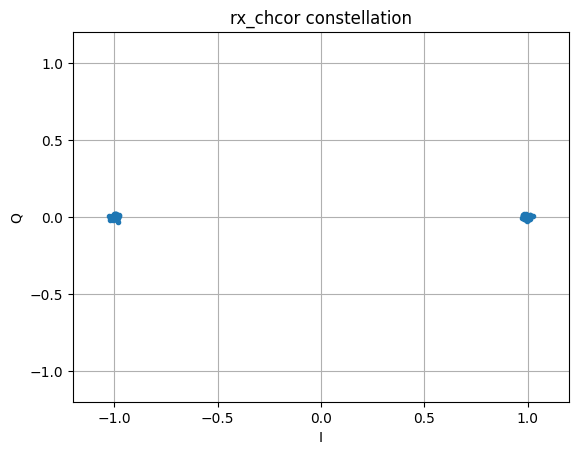

In [7]:
# channel correction (single tap)
rx_chcor = rx_packet/hhat #received / estimated h

# Create the eye diagram
plt.figure
plt.plot(rx_chcor.real, rx_chcor.imag, '.')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('rx_chcor constellation')
plt.grid(True)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
# plt.axis('scaled')
# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.show()


In [8]:
whos

Variable                Type        Data/Info
---------------------------------------------
A                       ndarray     13x1: 13 elems, type `float64`, 104 bytes
L                       int         1
N                       int         13
Npacket_samples         int         656
SNRdb                   int         25
Ts                      float       2.6666666666666666e-09
adi                     module      <module 'adi' from 'C:\\U<...>kages\\adi\\__init__.py'>
barker                  ndarray     13: 13 elems, type `int32`, 52 bytes
beta                    int         1
bits                    ndarray     64: 64 elems, type `int32`, 256 bytes
center_freq             int         1000000000
channel                 function    <function channel at 0x00000244CCD77060>
channelResponse         ndarray     13: 13 elems, type `float64`, 104 bytes
corr                    ndarray     90: 90 elems, type `float64`, 720 bytes
delays                  list        n=5
distance              